https://github.com/MuthuJaguar/NER/blob/master/NER.ipynb

In [ ]:
# Need larger data for better fit

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


In [3]:
data = pd.read_csv("/Users/sdeshpande/Desktop/bioinformatices/NER-using-CRF-on-Clinical-Prescription/NLP_dataset.csv")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Saiprasad,NNP,Person
1,Sentence: 1,23,CD,O
2,Sentence: 1,years,NNS,O
3,Sentence: 1,Male,JJ,O
4,Sentence: 1,Capsule,NNP,Medicine
5,Sentence: 1,AXL,NNP,Medicine
6,Sentence: 1,250mg,CD,Dose
7,Sentence: 1,3,CD,Frequency
8,Sentence: 1,times,NNS,O
9,Sentence: 1,a,DT,O


In [4]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 80
Unique tags in corpus: 5


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
sentences[0]

[('Saiprasad', 'NNP', 'Person'),
 ('23', 'CD', 'O'),
 ('years', 'NNS', 'O'),
 ('Male', 'JJ', 'O'),
 ('Capsule', 'NNP', 'Medicine'),
 ('AXL', 'NNP', 'Medicine'),
 ('250mg', 'CD', 'Dose'),
 ('3', 'CD', 'Frequency'),
 ('times', 'NNS', 'O'),
 ('a', 'DT', 'O'),
 ('day', 'NN', 'O'),
 ('for', 'IN', 'O'),
 ('5', 'CD', 'Frequency'),
 ('days', 'NNS', 'O'),
 ('after', 'IN', 'O'),
 ('food', 'NN', 'Frequency'),
 (',', ',', 'O'),
 ('Tablet', 'NNP', 'Medicine'),
 ('Metrogyl', 'NNP', 'Medicine'),
 ('200mg', 'CD', 'Dose'),
 ('3', 'CD', 'Frequency'),
 ('times', 'NNS', 'O'),
 ('a', 'DT', 'O'),
 ('day', 'NN', 'O'),
 ('for', 'IN', 'O'),
 ('5', 'CD', 'Frequency'),
 ('days', 'NNS', 'O'),
 ('after', 'IN', 'O'),
 ('food', 'NN', 'Frequency'),
 (',', ',', 'O'),
 ('Tablet', 'NNP', 'Medicine'),
 ('Enzoflam', 'NNP', 'Medicine'),
 ('390mg', 'CD', 'Dose'),
 ('3', 'CD', 'Frequency'),
 ('times', 'NNS', 'O'),
 ('a', 'DT', 'O'),
 ('day', 'NN', 'O'),
 ('for', 'IN', 'O'),
 ('5', 'CD', 'Frequency'),
 ('days', 'NNS', 'O'),
 

In [10]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
word2idx

{'Female': 1,
 '100ml': 2,
 'Saiprasad': 3,
 'times': 4,
 'time': 5,
 'after': 6,
 'Verapamil-SR': 7,
 'food': 8,
 'breakfast': 9,
 'Capsule': 10,
 'Tablet': 11,
 'before': 12,
 '35': 13,
 'Vitamin ': 14,
 'a': 15,
 'Dolofer-600': 16,
 '250mg': 17,
 'week': 18,
 '20mg': 19,
 '32.5mg': 20,
 'triamcinolone': 21,
 'once': 22,
 '22': 23,
 'Pan-20': 24,
 ',': 25,
 'Dravid': 26,
 'Male': 27,
 'years': 28,
 'and': 29,
 'Shweta': 30,
 '.': 31,
 '21': 32,
 'SSKI': 33,
 'Tendulkar': 34,
 'oral': 35,
 'Rahul': 36,
 'B-complex': 37,
 'mouth': 38,
 'Azithromycin': 39,
 '500mg': 40,
 'lunch': 41,
 '7': 42,
 '(OTC)': 43,
 '5': 44,
 '200mg': 45,
 '23': 46,
 'years ': 47,
 'Mithali': 48,
 'Sachin': 49,
 'AXL': 50,
 'daily': 51,
 'days': 52,
 'Paracetamol': 53,
 'Alendronate': 54,
 'Sunil ': 55,
 'Shekhar': 56,
 '2': 57,
 'dinner': 58,
 'Pillai': 59,
 'Loxapine': 60,
 'Metrogyl': 61,
 'Syrup': 62,
 'solution': 63,
 'night': 64,
 '1': 65,
 'Acyclovir': 66,
 'sleeping': 67,
 'Enzoflam': 68,
 'Terphylate':

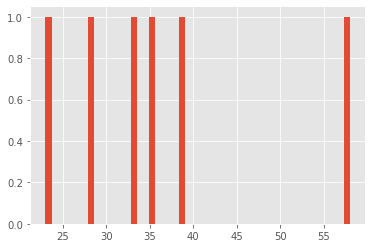

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [15]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [16]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            4050      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 5)             1005      
Total params: 125,855
Trainable params: 125,855
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [19]:
!pip install livelossplot

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [22]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)


history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    verbose=1
)


Epoch 1/3
1/1 [==============================] - 0s 344ms/step - loss: 1.6071 - accuracy: 0.2650 - val_loss: 1.5775 - val_accuracy: 0.7200
Epoch 2/3
1/1 [==============================] - 0s 23ms/step - loss: 1.5827 - accuracy: 0.6450 - val_loss: 1.5503 - val_accuracy: 0.7200
Epoch 3/3
1/1 [==============================] - 0s 20ms/step - loss: 1.5629 - accuracy: 0.6500 - val_loss: 1.5202 - val_accuracy: 0.7200
CPU times: user 3.3 s, sys: 454 ms, total: 3.76 s
Wall time: 2.78 s


In [23]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 859us/step - loss: 1.5202 - accuracy: 0.7200


[1.5201752185821533, 0.7200000286102295]

In [24]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Shweta         Person	O
Shekhar        Person	O
21             O	O
years          O	O
Female         O	O
Tablet         Medicine	O
Paracetamol    Medicine	O
500mg          Dose	O
2              Frequency	O
times          O	O
a              O	O
day            O	O
for            O	O
7              Frequency	O
days           O	O
after          O	O
breakfast      Frequency	O
and            O	O
dinner         Frequency	O
,              O	O
Tablet         Medicine	O
Alendronate    Medicine	O
250mg          Dose	O
1              Frequency	O
time           O	O
a              O	O
day            O	O
for            O	O
5              Frequency	O
days           O	O
after          O	O
dinner         Frequency	O
.              O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg          O	O
270mg